



# YOLOv8s with GTSRB + VNTS and fine tuning steps

## NOTE : THIS PART OF THE CODE SNIPPETS ARE THE PART OF THE INFORMATION TECHNOLOGY PROJECT OF  HTET AUNG (522K0048) AND HSU MYAT WAI MAUNG (522K0049)  FROM FACULTY OF INFORMATION TECHNOLOGY UNDER THE SUPERVISION OF TON DUC THANG UNIVERSITY.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.2 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import logging
import torch
import yaml
import shutil
from datetime import datetime
from ultralytics import YOLO
from google.colab import drive
from google.colab import files

# ==============================================================================
# 1. SETUP LOGGING
# ==============================================================================
log_dir = '/content/logs'
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'training_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('YOLOv8_Training_Pipeline')

logger.info("Starting YOLOv8 training pipeline on Google Colab.")

# ==============================================================================
# 2. MOUNT GOOGLE DRIVE & UNZIP DATASET
# ==============================================================================
def setup_dataset_from_drive(zip_name='merged_dataset.zip'):
    """
    Mounts Google Drive, locates the dataset zip file, and extracts it.
    """
    try:
        drive.mount('/content/drive', force_remount=True)
        drive_root = '/content/drive/MyDrive'
        logger.info(f"Google Drive mounted successfully at {drive_root}.")
    except Exception as e:
        logger.error(f"Failed to mount Google Drive: {str(e)}")
        raise RuntimeError("Google Drive mount failed. Please authorize access.")

    zip_file_path = os.path.join(drive_root, zip_name)
    extract_dir = '/content/'

    if not os.path.exists(zip_file_path):
        raise FileNotFoundError(f"Dataset zip file '{zip_name}' not found in Google Drive.")

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    logger.info("Dataset extracted successfully to /content/.")
    return drive_root

try:
    gdrive_root = setup_dataset_from_drive()
except (RuntimeError, FileNotFoundError) as e:
    logger.critical(f"Setup failed: {e}")


# ==============================================================================
# 3. VERIFY AND FIX DATASET CONFIGURATION
# ==============================================================================
dataset_root_path = '/content/merged_dataset'
data_yaml_path = os.path.join(dataset_root_path, 'data.yaml')

def fix_yaml_paths(yaml_path, dataset_root):
    """
    Corrects the paths in the data.yaml file to be absolute for the Colab environment.
    """
    if not os.path.exists(yaml_path):
        raise FileNotFoundError(f"data.yaml not found at {yaml_path}. Check your zip file structure.")

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    data['train'] = os.path.join(dataset_root, 'images', 'train')
    data['val'] = os.path.join(dataset_root, 'images', 'val')
    data['test'] = os.path.join(dataset_root, 'images', 'test')

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
    logger.info(f"Successfully corrected paths in {yaml_path}")

fix_yaml_paths(data_yaml_path, dataset_root_path)


# ==============================================================================
# 4. TRAIN THE YOLOv8 MODEL
# ==============================================================================
def train_model(data_yaml, resume_training=False):
    """
    Trains the YOLOv8 model, with an option to resume from the last checkpoint.
    """
    if resume_training:
        model_path = '/content/last (6).pt'
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Resume checkpoint not found at {model_path}. Cannot resume.")
        logger.info(f"Resuming training from checkpoint: {model_path}")
        model = YOLO(model_path)
    else:
        logger.info("Starting a new training run from 'yolov8s.pt'.")
        model = YOLO('yolov8s.pt')

    device_to_use = 0 if torch.cuda.is_available() else 'cpu'
    logger.info(f"Training device selected: {'GPU' if device_to_use == 0 else 'CPU'}")

    results = model.train(
        data=data_yaml,
        epochs=120,
        imgsz=640,
        batch=16,
        name='traffic_sign_model_final',
        patience=10,
        optimizer='AdamW',
        lr0=0.001,
        amp=True,
        device=device_to_use,
        augment=True,
        resume=resume_training
    )
    logger.info("Training completed successfully.")
    return model


trained_model = train_model(data_yaml_path, resume_training=True)


# ==============================================================================
# 5. SAVE RESULTS TO GOOGLE DRIVE
# ==============================================================================
def save_results_to_drive(model, drive_root_path):
    """
    Copies the entire results folder to Google Drive for permanent storage.
    """
    try:
        source_dir = model.trainer.save_dir
        run_name = os.path.basename(source_dir)
        destination_dir = os.path.join(drive_root_path, 'YOLOv8_Training_Results', run_name)

        if os.path.exists(destination_dir):
            shutil.rmtree(destination_dir)

        logger.info(f"Copying results from {source_dir} to {destination_dir}...")
        shutil.copytree(source_dir, destination_dir)
        shutil.copy(log_file, destination_dir)
        logger.info("Successfully saved all results and logs to Google Drive.")

    except Exception as e:
        logger.error(f"Failed to save results to Google Drive: {str(e)}", exc_info=True)

save_results_to_drive(trained_model, gdrive_root)

logger.info("--- YOLOv8 Training Pipeline Completed ---")


In [ ]:
from ultralytics import YOLO
import yaml
import os
import torch
import shutil

# --- 1. CONFIGURATION ---

BASE_MODEL_PATH = '/content/runs/detect/traffic_sign_model_final2/weights/last.pt'

DATASET_ROOT_PATH = '/content/merged_dataset'

ORIGINAL_YAML_PATH = os.path.join(DATASET_ROOT_PATH, 'data.yaml')


# ==============================================================================
# Helper function to fix dataset configuration paths
# ==============================================================================
def fix_yaml_paths(yaml_path, dataset_root):
    """
    Corrects the paths in the data.yaml file to be absolute for the Colab environment.
    """
    if not os.path.exists(yaml_path):
        raise FileNotFoundError(f"data.yaml not found at {yaml_path}. Check your zip file structure.")

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    data['train'] = os.path.join(dataset_root, 'images', 'train')
    data['val'] = os.path.join(dataset_root, 'images', 'val')
    data['test'] = os.path.join(dataset_root, 'images', 'test')

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
    print(f"Successfully corrected paths in {yaml_path}")


try:
    fix_yaml_paths(ORIGINAL_YAML_PATH, DATASET_ROOT_PATH)
except FileNotFoundError as e:
    print(f"Error during path fixing: {e}")
    raise


with open(ORIGINAL_YAML_PATH, 'r') as f:
    data_config = yaml.safe_load(f)

print(f"Loaded data_config with paths: train={data_config.get('train')}, val={data_config.get('val')}, test={data_config.get('test')}") # Debugging print


# --- 2. CREATE A NEW YAML FILE FOR VIETNAM-ONLY DATA ---
print("\nCreating a new YAML file for fine-tuning on Vietnamese data only...")

vietnam_train_txt = os.path.join(DATASET_ROOT_PATH, 'vietnam_train.txt')
vietnam_val_txt = os.path.join(DATASET_ROOT_PATH, 'vietnam_val.txt')

# Filter the original training images to include only Vietnamese ones
original_train_path = data_config['train']
print(f"Attempting to read training images from: {original_train_path}") # Debugging print
with open(vietnam_train_txt, 'w') as f:
    # Ensure the directory exists before listing files
    if os.path.exists(original_train_path):
        all_train_images = os.listdir(original_train_path)
        print(f"Total files found in training directory: {len(all_train_images)}") # Debugging print
        print(f"Contents of training directory (first 10): {all_train_images[:10]}...") # Debugging print
        vietnam_train_images_count = 0
        for img_name in all_train_images:
            if 'gtsrb_' not in img_name: # This condition identifies non-GTSRB files
                f.write(os.path.join(original_train_path, img_name) + '\n')
                vietnam_train_images_count += 1
        print(f"Number of Vietnamese training images identified: {vietnam_train_images_count}") # Debugging print
    else:
        print(f"Warning: Training directory not found: {original_train_path}")


# Filter the original validation images
original_val_path = data_config['val']
print(f"\nAttempting to read validation images from: {original_val_path}") # Debugging print
# Add an explicit check for the validation directory
print(f"Validation directory exists: {os.path.exists(original_val_path)}")
with open(vietnam_val_txt, 'w') as f:
    # Ensure the directory exists before listing files
    if os.path.exists(original_val_path):
        all_val_images = os.listdir(original_val_path)
        print(f"Total files found in validation directory: {len(all_val_images)}") # Debugging print
        print(f"Contents of validation directory (first 10): {all_val_images[:10]}...") # Debugging print
        vietnam_val_images_count = 0
        for img_name in all_val_images:
            if 'gtsrb_' not in img_name:
                f.write(os.path.join(original_val_path, img_name) + '\n')
                vietnam_val_images_count += 1
        print(f"Number of Vietnamese validation images identified: {vietnam_val_images_count}") # Debugging print
    else:
         print(f"Warning: Validation directory not found: {original_val_path}")

# Print contents of generated files
if os.path.exists(vietnam_train_txt):
    with open(vietnam_train_txt, 'r') as f:
        print(f"\nContents of {vietnam_train_txt} (first 10 lines): {f.readlines()[:10]}...")
else:
    print(f"\n{vietnam_train_txt} was not created.")

if os.path.exists(vietnam_val_txt):
    with open(vietnam_val_txt, 'r') as f:
        print(f"Contents of {vietnam_val_txt} (first 10 lines): {f.readlines()[:10]}...")
else:
     print(f"\n{vietnam_val_txt} was not created.")


# Create the new YAML config for fine-tuning
finetune_yaml_path = os.path.join(DATASET_ROOT_PATH, 'data_vietnam_only.yaml')
data_config['train'] = vietnam_train_txt
data_config['val'] = vietnam_val_txt

with open(finetune_yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print(f"\nFine-tuning YAML created at: {finetune_yaml_path}")


# --- 3. RUN THE FINE-TUNING PROCESS ---
print(f"\nLoading base model from: {BASE_MODEL_PATH}")
if not os.path.exists(BASE_MODEL_PATH):
    print(f"Error: Base model not found at {BASE_MODEL_PATH}. Please ensure best.pt exists.")

    raise FileNotFoundError(f"Base model not found at {BASE_MODEL_PATH}")


model = YOLO(BASE_MODEL_PATH)

# Determine device
device_to_use = 0 if torch.cuda.is_available() else 'cpu'
print(f"Fine-tuning device selected: {'GPU' if device_to_use == 0 else 'CPU'}")

print("Starting fine-tuning process with a low learning rate...")
# Fine-tune the model on the Vietnam-only data
results = model.train(
    data=finetune_yaml_path,
    epochs=50,  # Train for fewer epochs
    lr0=0.0001, # CRITICAL: Use a very low learning rate
    name='traffic_sign_model_finetuned_vn',
    patience=5,
    device=device_to_use,
    imgsz=640,
    batch=16
)

print("\n--- Fine-tuning complete! ---")
print("A new, specialized model has been saved in the 'runs/detect/traffic_sign_model_finetuned_vn' folder.")
print("Use the 'best.pt' from this new folder for improved performance on Vietnamese signs.")

Successfully corrected paths in /content/merged_dataset/data.yaml
Loaded data_config with paths: train=/content/merged_dataset/images/train, val=/content/merged_dataset/images/val, test=/content/merged_dataset/images/test

Creating a new YAML file for fine-tuning on Vietnamese data only...
Attempting to read training images from: /content/merged_dataset/images/train
Total files found in training directory: 19175
Contents of training directory (first 10): ['gtsrb_03620.png', 'vnts_IMG_4010-MOV_out0012_png.rf.4a2fd2d2f7ebf814c973970c7de4d56b.jpg', 'gtsrb_06344.png', 'vnts_IMG_4139-MOV_out0004_png.rf.1b91b60db4c1e24dd4fc518f4c9b5aab.jpg', 'vnts_image_219_jpg.rf.dce9a60e1a6f8856e2ef7c4aab9b27f1.jpg', 'vnts_IMG_4055-MOV_out0028_png.rf.6b73f4350db67be0d0593b730d287a4d.jpg', 'gtsrb_00755.png', 'vnts_IMG_4192-MOV_out0054_png.rf.51bc44e58808fec4c6ae63cc890bafe3.jpg', 'gtsrb_03667.png', 'vnts_IMG_4110-MOV_out0009_png.rf.bb1634b1e261314920c2db88320dfa24.jpg']...
Number of Vietnamese training imag

In [ ]:
model = YOLO('/content/runs/detect/traffic_sign_model_finetuned_vn/weights/best.pt')


metrics = model.val(data='/content/merged_dataset/data_vietnam_only.yaml', split='test')

# The metrics object will contain precision, recall, mAP50, mAP50-95, etc.
print(f"mAP50-95 on test set: {metrics.box.map}")
print(f"mAP50 on test set: {metrics.box.map50}")

Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,158,866 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.5±10.0 MB/s, size: 39.2 KB)
val: Scanning /content/merged_dataset/labels/test... 2119 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2119/2119 1.3Kit/s 1.7s
val: New cache created: /content/merged_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 133/133 4.7it/s 28.5s
                   all       2119       2757      0.936      0.911       0.95      0.846
           speed_limit        517        517          1      0.975      0.995      0.957
       end_speed_limit         34         34      0.993          1      0.995      0.954
            no_passing        124        124       0.99      0.871      0.947      0.821
     no_heavy_vehicles        104        104      0.997      0.981   

--- Starting Quantitative Evaluation ---

Evaluating Original Model (trained on combined data)...
Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,158,866 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 614.6±594.7 MB/s, size: 18.0 KB)
val: Scanning /content/merged_dataset/labels/test.cache... 2119 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2119/2119 3.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 133/133 5.5it/s 24.4s
                   all       2119       2757      0.903      0.956       0.95      0.851
Speed: 0.2ms preprocess, 8.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Original Model evaluation complete.

Evaluating Fine-tuned Model (trained on VNTS only)...
Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,15

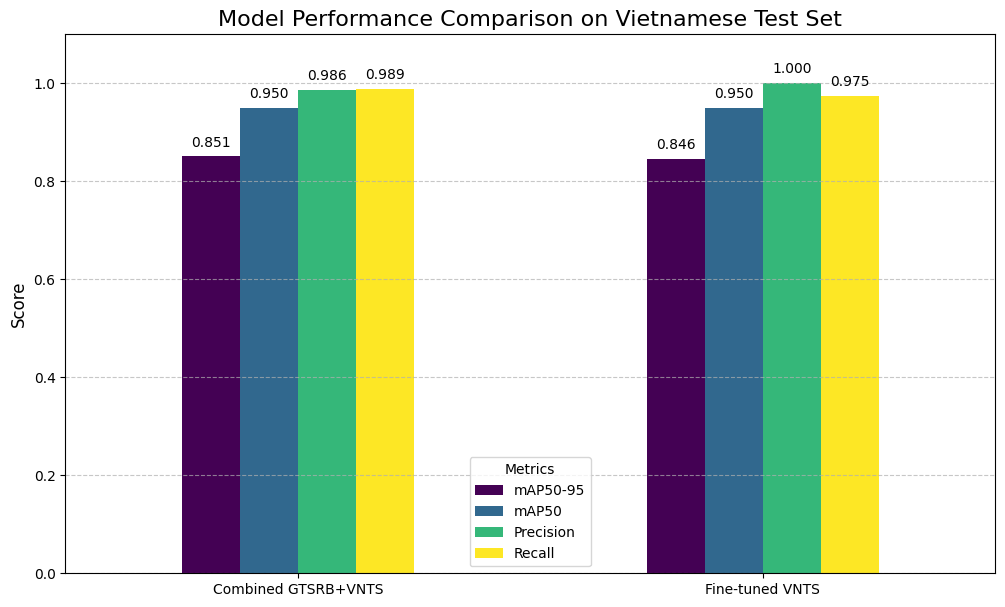

Chart saved to /content/comparison_chart.png

--- Generating Visual Side-by-Side Comparisons ---

Processing image: gtsrb_04471.png
Results saved to /content/runs/detect/predict3
Original model result saved to: /content/runs/detect/predict3/gtsrb_04471.png
Results saved to /content/runs/detect/predict4
Fine-tuned model result saved to: /content/runs/detect/predict4/gtsrb_04471.png
Error loading original model result image: /content/runs/detect/predict3/gtsrb_04471.png
Skipping visual comparison for gtsrb_04471.png due to image loading error.

Processing image: vnts_IMG_4077-MOV_out0018_png.rf.d3a3fd70409896bb1272bcb340695b78.jpg
Results saved to /content/runs/detect/predict5
Original model result saved to: /content/runs/detect/predict5/vnts_IMG_4077-MOV_out0018_png.rf.d3a3fd70409896bb1272bcb340695b78.jpg
Results saved to /content/runs/detect/predict6
Fine-tuned model result saved to: /content/runs/detect/predict6/vnts_IMG_4077-MOV_out0018_png.rf.d3a3fd70409896bb1272bcb340695b78.jpg


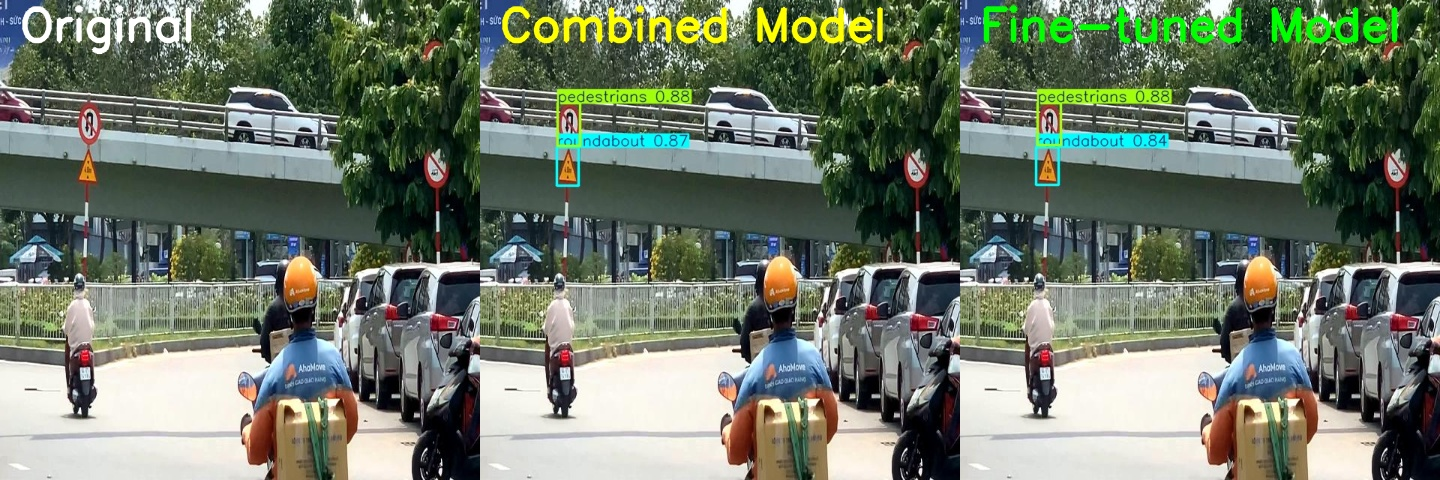


Processing image: gtsrb_10975.png
Results saved to /content/runs/detect/predict7
Original model result saved to: /content/runs/detect/predict7/gtsrb_10975.png
Results saved to /content/runs/detect/predict8
Fine-tuned model result saved to: /content/runs/detect/predict8/gtsrb_10975.png
Error loading original model result image: /content/runs/detect/predict7/gtsrb_10975.png
Skipping visual comparison for gtsrb_10975.png due to image loading error.

--- Comparison Complete! ---


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ultralytics import YOLO
from IPython.display import display, Image


original_model_path = '/content/best.pt'

# Path to the model fine-tuned on the Vietnamese-only dataset
finetuned_model_path = '/content/runs/detect/traffic_sign_model_finetuned_vn/weights/best.pt'

# Path to  dataset's YAML configuration file
data_yaml_path = '/content/merged_dataset/data_vietnam_only.yaml'

# Path to the directory with Vietnamese test images
test_image_dir = '/content/merged_dataset/images/test'

# --- Step 1: Quantitative Evaluation ---
print("--- Starting Quantitative Evaluation ---")

metrics_data = []

# Evaluate the Original Model
if os.path.exists(original_model_path):
    print("\nEvaluating Original Model (trained on combined data)...")
    original_model = YOLO(original_model_path)
    original_metrics = original_model.val(data=data_yaml_path, split='test', save_json=False, plots=False, verbose=False)

    metrics_data.append({
        'Model': 'Combined GTSRB+VNTS',
        'mAP50-95': original_metrics.box.map,
        'mAP50': original_metrics.box.map50,
        'Precision': original_metrics.box.p[0], # Using precision for 'all' classes
        'Recall': original_metrics.box.r[0]    # Using recall for 'all' classes
    })
    print("Original Model evaluation complete.")
else:
    print(f"ERROR: Original model not found at '{original_model_path}'. Please upload and name it correctly.")

# Evaluate the Fine-tuned Model
if os.path.exists(finetuned_model_path):
    print("\nEvaluating Fine-tuned Model (trained on VNTS only)...")
    finetuned_model = YOLO(finetuned_model_path)
    finetuned_metrics = finetuned_model.val(data=data_yaml_path, split='test', save_json=False, plots=False, verbose=False)

    metrics_data.append({
        'Model': 'Fine-tuned VNTS',
        'mAP50-95': finetuned_metrics.box.map,
        'mAP50': finetuned_metrics.box.map50,
        'Precision': finetuned_metrics.box.p[0],
        'Recall': finetuned_metrics.box.r[0]
    })
    print("Fine-tuned Model evaluation complete.")
else:
    print(f"ERROR: Fine-tuned model not found at '{finetuned_model_path}'. Check the path.")

# --- Step 2: Generate Comparison Chart ---
if metrics_data:
    print("\n--- Generating Performance Comparison Chart ---")
    df = pd.DataFrame(metrics_data)
    df.set_index('Model', inplace=True)

    ax = df.plot(kind='bar', figsize=(12, 7), rot=0, colormap='viridis')
    plt.title('Model Performance Comparison on Vietnamese Test Set', fontsize=16)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Metrics')

    # Add the values on top of the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    chart_path = '/content/comparison_chart.png'
    plt.savefig(chart_path)
    plt.show()
    print(f"Chart saved to {chart_path}")
else:
    print("\nSkipping chart generation because no evaluation data was collected.")


# --- Step 3: Visual Side-by-Side Comparison ---
print("\n--- Generating Visual Side-by-Side Comparisons ---")

# Function to create a comparison image
def create_comparison_image(original_img_path, res_orig_path, res_tuned_path):
    orig_img = cv2.imread(original_img_path)
    img_orig_model = cv2.imread(res_orig_path)
    img_tuned_model = cv2.imread(res_tuned_path)

    if orig_img is None:
        print(f"Error loading original image: {original_img_path}")
        return None
    if img_orig_model is None:
        print(f"Error loading original model result image: {res_orig_path}")
        return None
    if img_tuned_model is None:
        print(f"Error loading fine-tuned model result image: {res_tuned_path}")
        return None

    # Resize images to have the same height for consistent stacking
    target_height = 480
    scale1 = target_height / orig_img.shape[0]
    orig_img = cv2.resize(orig_img, (int(orig_img.shape[1] * scale1), target_height))

    scale2 = target_height / img_orig_model.shape[0]
    img_orig_model = cv2.resize(img_orig_model, (int(img_orig_model.shape[1] * scale2), target_height))

    scale3 = target_height / img_tuned_model.shape[0]
    img_tuned_model = cv2.resize(img_tuned_model, (int(img_tuned_model.shape[1] * scale3), target_height))

    # Add text labels
    cv2.putText(orig_img, 'Original', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3, cv2.LINE_AA)
    cv2.putText(img_orig_model, 'Combined Model', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, cv2.LINE_AA)
    cv2.putText(img_tuned_model, 'Fine-tuned Model', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)

    # Stack images horizontally
    comparison = np.hstack((orig_img, img_orig_model, img_tuned_model))
    return comparison

# Select a few images to test
test_images = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]

if test_images and os.path.exists(original_model_path) and os.path.exists(finetuned_model_path):
    for img_path in test_images:
        print(f"\nProcessing image: {os.path.basename(img_path)}")

        # Prediction with original model
        res_orig = YOLO(original_model_path).predict(img_path, save=True, verbose=False)
        res_orig_path = os.path.join(res_orig[0].save_dir, os.path.basename(img_path))
        print(f"Original model result saved to: {res_orig_path}")

        # Prediction with fine-tuned model
        res_tuned = YOLO(finetuned_model_path).predict(img_path, save=True, verbose=False)
        res_tuned_path = os.path.join(res_tuned[0].save_dir, os.path.basename(img_path))
        print(f"Fine-tuned model result saved to: {res_tuned_path}")


        # Create and display the comparison montage
        comparison_montage = create_comparison_image(
            img_path,
            res_orig_path,
            res_tuned_path
        )

        if comparison_montage is not None:
            # Save and display the final comparison image
            montage_path = f'/content/comparison_{os.path.basename(img_path)}'
            cv2.imwrite(montage_path, comparison_montage)
            display(Image(filename=montage_path))
        else:
            print(f"Skipping visual comparison for {os.path.basename(img_path)} due to image loading error.")

else:
    print("\nSkipping visual comparison due to missing models or test images.")

print("\n--- Comparison Complete! ---")

Loading YOLOv11 model...
Loading YOLOv8 model...
Evaluating YOLOv11 on test set...
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv11s summary (fused): 72 layers, 11,158,866 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 611.3±667.9 MB/s, size: 16.3 KB)
val: Scanning /content/merged_dataset/labels/test... 2119 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2119/2119 2.6Kit/s 0.8s
val: New cache created: /content/merged_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 133/133 5.2it/s 25.5s
                   all       2119       2757      0.905      0.928      0.936      0.829
Speed: 0.9ms preprocess, 8.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Evaluating YOLOv8 on test set...
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,158,866 para

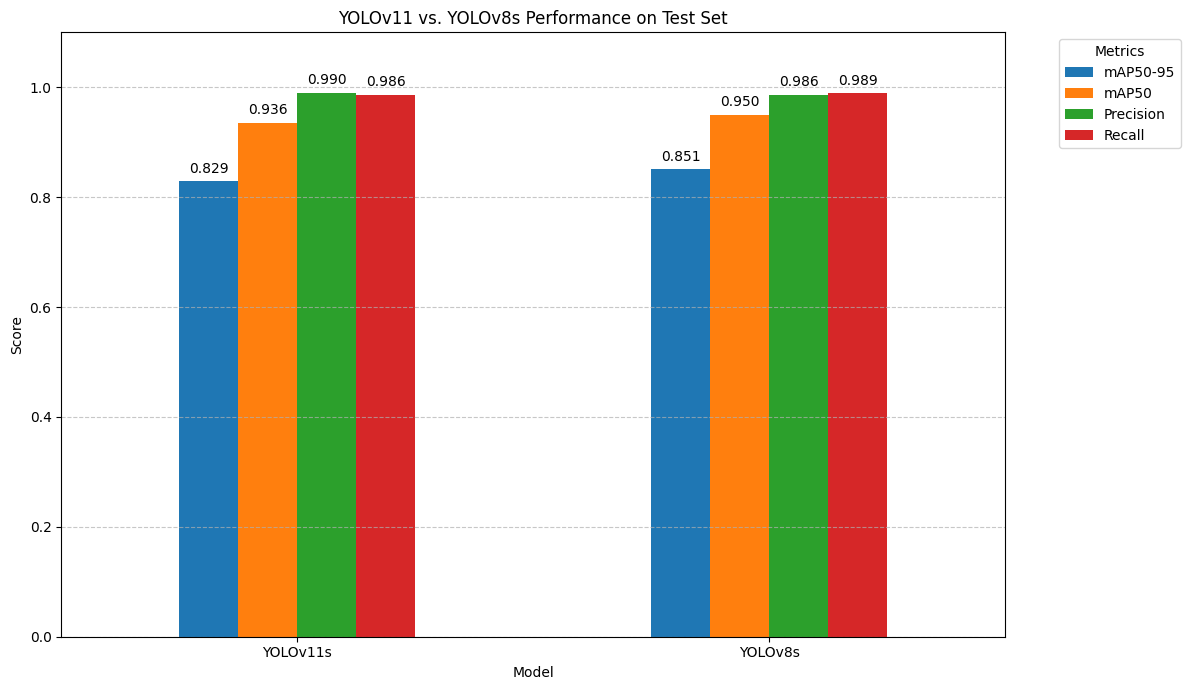

Chart saved as 'model_comparison_chart.png'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- 1. DEFINE YOUR MODEL PATHS ---
# !!! Replace these with the actual paths to your trained models !!!
yolov11_model_path = "/content/yolo11_best.pt"
yolov8_model_path = "/content/yolov8_best.pt"
data_yaml_path = "/content/merged_dataset/data.yaml"

# --- 2. LOAD MODELS ---
print("Loading YOLOv11 model...")
model_v11 = YOLO(yolov11_model_path)

print("Loading YOLOv8 model...")
model_v8 = YOLO(yolov8_model_path)

# --- 3. RUN EVALUATION (VALIDATION ON TEST SET) ---
print("Evaluating YOLOv11 on test set...")
metrics_v11 = model_v11.val(data=data_yaml_path, split='test', plots=False, verbose=False)

print("Evaluating YOLOv8 on test set...")
metrics_v8 = model_v8.val(data=data_yaml_path, split='test', plots=False, verbose=False)

# --- 4. PREPARE DATA FOR PLOTTING ---
metrics_data = [
    {
        'Model': 'YOLOv11s',
        'mAP50-95': metrics_v11.box.map,
        'mAP50': metrics_v11.box.map50,
        'Precision': metrics_v11.box.p[0], # [0] is for the 'all' class
        'Recall': metrics_v11.box.r[0]    # [0] is for the 'all' class
    },
    {
        'Model': 'YOLOv8s',
        'mAP50-95': metrics_v8.box.map,
        'mAP50': metrics_v8.box.map50,
        'Precision': metrics_v8.box.p[0],
        'Recall': metrics_v8.box.r[0]
    }
]

df = pd.DataFrame(metrics_data)
df.set_index('Model', inplace=True)

print("--- Comparison Metrics ---")
print(df)

# --- 5. GENERATE BAR CHART DIAGRAM ---
print("\nGenerating performance comparison chart...")

ax = df.plot(kind='bar', figsize=(12, 7), rot=0, title='YOLOv11 vs. YOLOv8s Performance on Test Set')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title ='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.savefig('model_comparison_chart.png')
plt.show()

print("Chart saved as 'model_comparison_chart.png'")